**AutoGenAgent (a GPT‑4–based agent)**

In [15]:
pip install openai==0.28

  Using cached openai-0.28.0-py3-none-any.whl.metadata (13 kB)
Using cached openai-0.28.0-py3-none-any.whl (76 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.70.0
    Uninstalling openai-1.70.0:
      Successfully uninstalled openai-1.70.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.3.12 requires openai<2.0.0,>=1.68.2, but you have openai 0.28.0 which is incompatible.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OpenAI API key loaded and set.
API Test Response: Hello! How can I assist you today?
Loading data from /content/drive/MyDrive/AIPM/cleaned_data.csv...
Data loaded successfully. Shape: (6391, 54)
Sampled data preview:
     timestamp  activityID  heart_rate    hand_1    hand_2    hand_3  \
683      38.03          24       138.0 -1.585261  1.177639 -0.759492   
680      38.00          24       138.0 -1.585261  2.649549  0.072815   
686      38.06          24       138.0 -1.585261  0.022390 -0.773286   
652      37.72          24       138.0 -1.585261 -0.128791 -1.881297   
664      37.84          24       138.0 -1.585261 -1.616008  0.480730   

       hand_4    hand_5    hand_6    hand_7  ...   ankle_8   ankle_9  \
683 -2.106685  1.560840 -0.591233 -2.272932  ...  1.086325  1.303878   
680 -2.259521  2.966081  0.326489 -2.451002  ...  0.963022  1.117782   
686 -

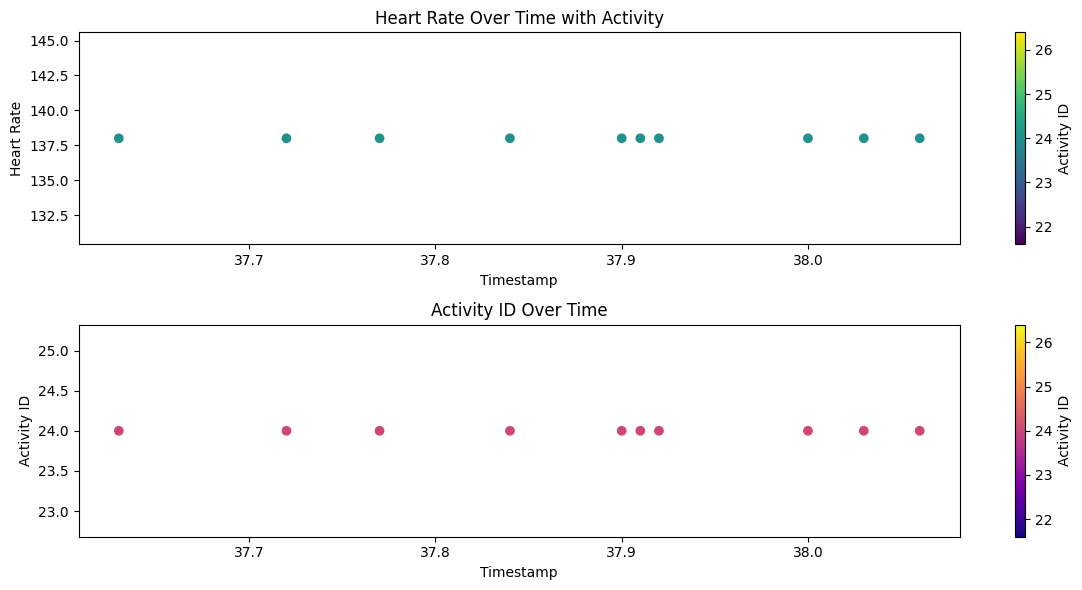


Labeling Results from AutoGenAgent:
Window 0: {'label': 'Running', 'tokens': 4425, 'time': 1.4402856826782227}
Window 1: {'label': 'Running', 'tokens': 5277, 'time': 0.930689811706543}
Window 2: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.08676266670227051}
Window 3: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.08917450904846191}
Window 4: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.08741641044616699}
Window 5: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.10445070266723633}
Window 6: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.08292555809020996}
Window 7: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.0809335708618164}
Window 8: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.08841156959533691}
Window 9: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.10527300834655762}


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import json
import openai

# -------------------------------
# Step 0: Mount Google Drive and Load OpenAI API Key
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')

key_file_path = "/content/drive/MyDrive/AIPM/openai_key.txt"
with open(key_file_path, "r") as f:
    api_key = f.read().strip()
openai.api_key = api_key
print("OpenAI API key loaded and set.")

# Test the API key with a simple GPT-4 request
response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[{"role": "user", "content": "Hello, world!"}],
    max_tokens=50
)
print("API Test Response:", response.choices[0].message.content)

# -------------------------------
# Step 1: Data Loading
# -------------------------------
def load_data(file_path="/content/drive/MyDrive/AIPM/cleaned_data.csv"):
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
    return df

df = load_data()

# For testing: Filter and sample the data
timestamp_start = 37.6
timestamp_end = 38.1
filtered_df = df[(df['timestamp'] >= timestamp_start) & (df['timestamp'] <= timestamp_end)]
sampled_df = filtered_df.sample(n=min(10, len(filtered_df)), random_state=42)
print("Sampled data preview:")
print(sampled_df.head())

# -------------------------------
# Step 2: Define a Plain-Text Sensor Context
# -------------------------------
def get_sensor_context():
    return (
        "The PAMAP2 Physical Activity Monitoring dataset contains sensor data from 9 subjects "
        "performing 18 different physical activities. Each subject wore three IMUs placed on the "
        "wrist, chest, and ankle, along with a heart rate monitor. The dataset includes timestamped "
        "readings with an activity label and 52 sensor attributes per instance. These attributes include "
        "3D acceleration, gyroscope, magnetometer, and orientation data from each sensor, as well as heart rate. "
        "These detailed sensor readings are used to identify specific physical activities."
    )

sensor_context = get_sensor_context()

# -------------------------------
# Step 3: Define the Base Agent and AutoGenAgent Using GPT-4
# -------------------------------
class BaseAgent:
    def auto_label(self, prompt: str) -> str:
        raise NotImplementedError("Subclasses must implement auto_label()")

class GPT4AgentBase(BaseAgent):
    def auto_label(self, prompt: str) -> (str, int, float):
        start = time.time()
        try:
            response = openai.ChatCompletion.create(
                model="gpt-4",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=50,
                temperature=0.0
            )
            elapsed = time.time() - start
            token_usage = response.get("usage", {}).get("total_tokens", 0)
            label = response.choices[0].message.content.strip()
            return label, token_usage, elapsed
        except Exception as e:
            elapsed = time.time() - start
            print("Error in GPT4AgentBase:", e)
            return "Fallback label: Unknown activity", 0, elapsed

class AutoGenAgent(GPT4AgentBase):
    def auto_label(self, prompt: str) -> (str, int, float):
        modified_prompt = "AutoGen Approach: " + prompt
        return super().auto_label(modified_prompt)

# -------------------------------
# Step 4: Helper Functions for Prompt Creation and Sliding Window
# -------------------------------
window_size = 5

def create_prompt(df_window):
    """Create a prompt from a sliding window of data including sensor context."""
    window_data = df_window.to_dict(orient='records')
    prompt = (
        f"{sensor_context}\n\n"
        f"Window Data:\n{json.dumps(window_data, indent=2)}\n\n"
        "Based on the above sensor data, assign a specific physical activity label (e.g., 'walking', 'running', 'sitting', etc.). "
        "Respond only with the label in plain text."
    )
    return prompt

def label_data_with_context(idx, df, agent: BaseAgent) -> dict:
    """
    Uses a sliding window of rows from the DataFrame to create a prompt and generates a label using the given agent.
    Returns a dictionary with the label, token usage, and processing time.
    """
    subset = df.iloc[max(0, idx - window_size): min(len(df), idx + window_size)]
    prompt = create_prompt(subset)
    try:
        label, tokens, elapsed = agent.auto_label(prompt)
        return {"label": label, "tokens": tokens, "time": elapsed}
    except Exception as e:
        print(f"Error labeling index {idx}: {e}")
        return {"label": "Dummy label", "tokens": 0, "time": 0}

# -------------------------------
# Step 5: Instantiate AutoGenAgent and Run Labeling
# -------------------------------
agent = AutoGenAgent()

# For each row in the sampled data, label using the sliding window context
results = [label_data_with_context(i, sampled_df, agent) for i in range(len(sampled_df))]

# Add the labels to the DataFrame for visualization
sampled_df["label"] = [res["label"] for res in results]

# -------------------------------
# Step 6: Visualization of the Data with Labels
# -------------------------------
plt.figure(figsize=(12, 6))
hr_col = 'heart_rate' if 'heart_rate' in sampled_df.columns else 'heartrate'

plt.subplot(2, 1, 1)
plt.scatter(sampled_df["timestamp"], sampled_df[hr_col], c=sampled_df["activityID"], cmap='viridis')
plt.xlabel("Timestamp")
plt.ylabel("Heart Rate")
plt.title("Heart Rate Over Time with Activity")
plt.colorbar(label="Activity ID")

plt.subplot(2, 1, 2)
plt.scatter(sampled_df["timestamp"], sampled_df["activityID"], c=sampled_df["activityID"], cmap='plasma')
plt.xlabel("Timestamp")
plt.ylabel("Activity ID")
plt.title("Activity ID Over Time")
plt.colorbar(label="Activity ID")
plt.tight_layout()
plt.show()

# Print out labeling results
print("\nLabeling Results from AutoGenAgent:")
for i, res in enumerate(results):
    print(f"Window {i}: {res}")

LangGraphAgent – Entire Data Auto-Labeling using GPT-**4** bold text

In [4]:
!pip install langgraph langchain-openai

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OpenAI API key loaded and set.
API Test Response: Hello! How can I assist you today?
Loading data from /content/drive/MyDrive/AIPM/cleaned_data.csv...
Data loaded successfully. Shape: (6391, 54)
Sampled data preview:
     timestamp  activityID  heart_rate    hand_1    hand_2    hand_3  \
683      38.03          24       138.0 -1.585261  1.177639 -0.759492   
680      38.00          24       138.0 -1.585261  2.649549  0.072815   
686      38.06          24       138.0 -1.585261  0.022390 -0.773286   
652      37.72          24       138.0 -1.585261 -0.128791 -1.881297   
664      37.84          24       138.0 -1.585261 -1.616008  0.480730   

       hand_4    hand_5    hand_6    hand_7  ...   ankle_8   ankle_9  \
683 -2.106685  1.560840 -0.591233 -2.272932  ...  1.086325  1.303878   
680 -2.259521  2.966081  0.326489 -2.451002  ...  0.963022  1.117782   
686 -

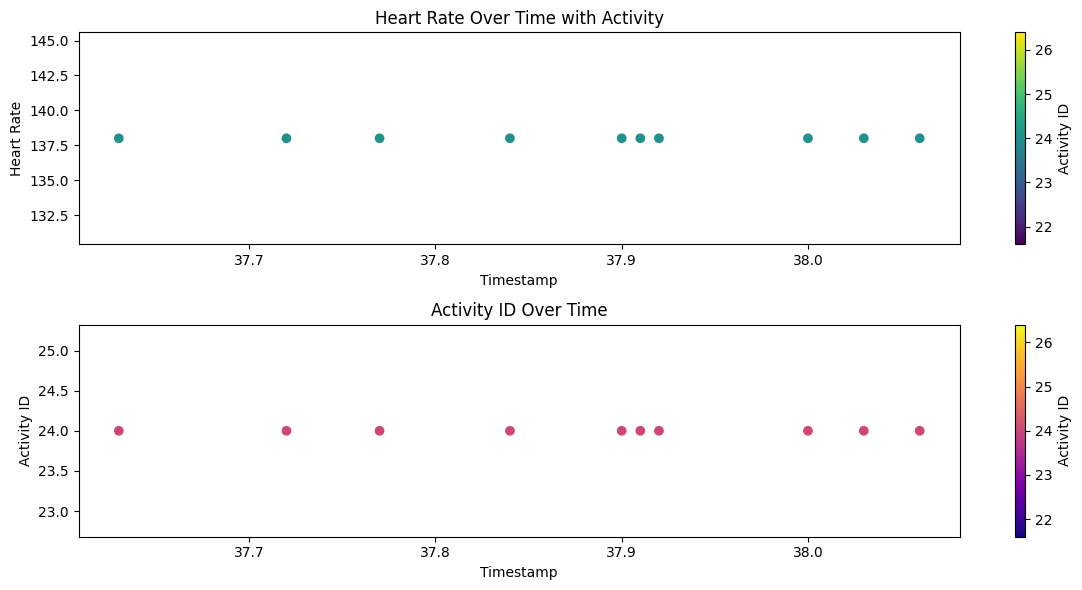


Labeling Results from LangGraphAgent:
Window 0: {'label': 'The dataset does not provide enough information to accurately determine the specific physical activity.', 'tokens': 4439, 'time': 1.293795108795166}
Window 1: {'label': 'The dataset does not provide enough information to accurately determine the specific physical activity.', 'tokens': 5291, 'time': 1.6622216701507568}
Window 2: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.08308076858520508}
Window 3: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.07073664665222168}
Window 4: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.07639002799987793}
Window 5: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.07443642616271973}
Window 6: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.08339309692382812}
Window 7: {'label': 'Fallback label: Unknown activity', 'tokens': 0, 'time': 0.06876897811889648}
Window 8: {'label': 'Fallback la

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import json
import openai

# -------------------------------
# Step 0: Mount Google Drive and Load OpenAI API Key
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')

key_file_path = "/content/drive/MyDrive/AIPM/openai_key.txt"
with open(key_file_path, "r") as f:
    api_key = f.read().strip()
openai.api_key = api_key
print("OpenAI API key loaded and set.")

# Test the API key with a simple GPT-4 request
response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[{"role": "user", "content": "Hello, world!"}],
    max_tokens=50
)
print("API Test Response:", response.choices[0].message.content)

# -------------------------------
# Step 1: Data Loading
# -------------------------------
def load_data(file_path="/content/drive/MyDrive/AIPM/cleaned_data.csv"):
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
    return df

df = load_data()

# For testing: Filter and sample the data (optional)
timestamp_start = 37.6
timestamp_end = 38.1
filtered_df = df[(df['timestamp'] >= timestamp_start) & (df['timestamp'] <= timestamp_end)]
sampled_df = filtered_df.sample(n=min(10, len(filtered_df)), random_state=42)
print("Sampled data preview:")
print(sampled_df.head())

# -------------------------------
# Step 2: Define a Plain-Text Sensor Context
# -------------------------------
def get_sensor_context():
    return (
        "The PAMAP2 Physical Activity Monitoring dataset contains sensor data from 9 subjects "
        "performing 18 different physical activities. Each subject wore three IMUs placed on the "
        "wrist, chest, and ankle, along with a heart rate monitor. The dataset includes timestamped "
        "readings with an activity label and 52 sensor attributes per instance. These attributes include "
        "3D acceleration, gyroscope, magnetometer, and orientation data from each sensor, as well as heart rate. "
        "These detailed sensor readings are used to identify specific physical activities."
    )

sensor_context = get_sensor_context()

# -------------------------------
# Step 3: Define the Base Agent and LangGraphAgent Using GPT-4
# -------------------------------
class BaseAgent:
    def auto_label(self, prompt: str) -> str:
        raise NotImplementedError("Subclasses must implement auto_label()")

class GPT4AgentBase(BaseAgent):
    def auto_label(self, prompt: str) -> (str, int, float):
        start = time.time()
        try:
            response = openai.ChatCompletion.create(
                model="gpt-4",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=50,
                temperature=0.0
            )
            elapsed = time.time() - start
            token_usage = response.get("usage", {}).get("total_tokens", 0)
            label = response.choices[0].message.content.strip()
            return label, token_usage, elapsed
        except Exception as e:
            elapsed = time.time() - start
            print("Error in GPT4AgentBase:", e)
            return "Fallback label: Unknown activity", 0, elapsed

class LangGraphAgent(GPT4AgentBase):
    def auto_label(self, prompt: str) -> (str, int, float):
        modified_prompt = "LangGraph Approach: " + prompt
        return super().auto_label(modified_prompt)

# -------------------------------
# Step 4: Helper Functions for Prompt Creation (using sliding window)
# -------------------------------
window_size = 5

def create_prompt(df_window):
    """Create a prompt from a sliding window of data including sensor context."""
    window_data = df_window.to_dict(orient='records')
    prompt = (
        f"{sensor_context}\n\n"
        f"Window Data:\n{json.dumps(window_data, indent=2)}\n\n"
        "Based on the above sensor data, assign a specific physical activity label (e.g., 'walking', 'running', 'sitting', etc.). "
        "Respond only with the label in plain text."
    )
    return prompt

def label_data_with_context(idx, df, agent: BaseAgent) -> dict:
    """
    Uses a sliding window of rows from the DataFrame to create a prompt and generates a label using the given agent.
    Returns a dictionary with the label, token usage, and processing time.
    """
    subset = df.iloc[max(0, idx - window_size): min(len(df), idx + window_size)]
    prompt = create_prompt(subset)
    try:
        label, tokens, elapsed = agent.auto_label(prompt)
        return {"label": label, "tokens": tokens, "time": elapsed}
    except Exception as e:
        print(f"Error labeling index {idx}: {e}")
        return {"label": "Dummy label", "tokens": 0, "time": 0}

# -------------------------------
# Step 5: Instantiate LangGraphAgent and Run Labeling on Sampled Data
# -------------------------------
agent = LangGraphAgent()

results = [label_data_with_context(i, sampled_df, agent) for i in range(len(sampled_df))]
sampled_df["label"] = [res["label"] for res in results]

# -------------------------------
# Step 6: Visualization of the Data with Labels
# -------------------------------
plt.figure(figsize=(12, 6))
hr_col = 'heart_rate' if 'heart_rate' in sampled_df.columns else 'heartrate'

plt.subplot(2, 1, 1)
plt.scatter(sampled_df["timestamp"], sampled_df[hr_col], c=sampled_df["activityID"], cmap='viridis')
plt.xlabel("Timestamp")
plt.ylabel("Heart Rate")
plt.title("Heart Rate Over Time with Activity")
plt.colorbar(label="Activity ID")

plt.subplot(2, 1, 2)
plt.scatter(sampled_df["timestamp"], sampled_df["activityID"], c=sampled_df["activityID"], cmap='plasma')
plt.xlabel("Timestamp")
plt.ylabel("Activity ID")
plt.title("Activity ID Over Time")
plt.colorbar(label="Activity ID")
plt.tight_layout()
plt.show()

# Print out labeling results
print("\nLabeling Results from LangGraphAgent:")
for i, res in enumerate(results):
    print(f"Window {i}: {res}")